In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rberga06.phylab import Datum as d
import math
from typing import Iterable

In [2]:
# Load data
files_day1 = [(f"day1:{i}", pd.read_csv(f"data/day1/TEK{i:05}.CSV", skiprows=15)) for i in range(51)]
files_day2 = [(f"day2:{i}", pd.read_csv(f"data/day2/TEK{i:05}.CSV", skiprows=15)) for i in range(26)]
files5A = files_day1[34:51] + files_day2[9:20]
files5B = files_day1[2:27] + files_day2[:9]
files6 = files_day1[27:34]
files_extra = files_day2[20:]
assert 2 + len(files5A) + len(files5B) + len(files6) + len(files_extra) == len(files_day1) + len(files_day2)

In [3]:
def zeri_v0(time: pd.Series, ch: pd.Series) -> list[float]:
    ch = ch - (ch.max() + ch.min())/2
    zeri: list[float] = []
    last_zero: list[float] = []
    last_i: int = -1
    for (_i, x) in time[ch.between(-1e-2,1e-2)].items():
        i2 = int(_i)
        if (i2 - last_i >= 5) and last_zero:
            # abbiamo trovato un nuovo zero
            zeri.append((last_zero[-1] + last_zero[0])/2)
            last_zero.clear()
        last_zero.append(x)
        last_i = i2
    if last_zero:
        zeri.append((last_zero[-1] + last_zero[0])/2)
    return zeri

def zeri_v1(time: pd.Series, ch: pd.Series, threshold: float = 3e-2) -> list[float]:
    ch -= (ch.max() + ch.min())/2
    zeri: list[float] = []
    this_zero: list[float] = []
    last_t: float = 0
    last_y: float | None = None
    t: float; y: float
    for (t, y) in zip(time, ch):
        if -threshold <= y <= threshold:  # questo conta come zero
            this_zero.append(t)
        elif this_zero:  # è appena finito uno zero
            zeri.append(sum(this_zero)/len(this_zero))
            this_zero.clear()
            last_y = y
        elif last_y is not None and (
            (last_y + threshold) * (y - threshold) < 0 or
            (last_y - threshold) * (y + threshold) < 0
        ): # abbiamo appena oltrepassato uno zero
            zeri.append((last_t + t)/2)
        # prepara la prossima iterazione
        last_t, last_y = t, y
    return zeri

In [4]:
def plot_all(files: Iterable[tuple[str, pd.DataFrame]]):
    for (i, f) in files:
        print(f"-[{i}]-" + "-"*77)
        time, ch1, ch2 = f["TIME"], f["CH1"], f["CH2"]
        fig, ax = plt.subplots()
        ax.plot(time, ch1 - (ch1.max() + ch1.min())/2)
        ax.plot(time, ch2)
        ax.axhline(0, color="0.0", linestyle="--", linewidth=1, rasterized=True)
        plt.show()

def analyze(files: Iterable[tuple[str, pd.DataFrame]]):
    fasi, ampiezze1, ampiezze2, ampiezze_rapporto, frequenze = [], [], [], [], []
    for (i, f) in files:
        we_have_to_plot = False
        print(f"-[{i}]-" + "-"*77)
        time, ch1, ch2 = f["TIME"], f["CH1"], f["CH2"]

        _zeri = zeri_v1(time, ch1)
        _diffs = [_zeri[i] - _zeri[i-1] for i in range(1, len(_zeri))]
        print(*[f"{1 / (2*x)} Hz" for x in _diffs], sep=", ")
        if len(_zeri) > 1:
            T = 2 * (sum(_diffs)/(len(_zeri)-1))
        else:
            print("[i] Non ci sono abbastanza zeri per valutare il periodo, proverò con massimo e minimo!")
            we_have_to_plot = True
            t_max, t_min = time[idx_max := ch1.idxmax()], time[idx_min := ch1.idxmin()]
            if ch1[idx_max] < 0:
                print("{!} Errore: Il massimo è negativo!")
                T = 0
            elif ch1[idx_min] > 0:
                print("{!} Errore: Il minimo è positivo!")
                T = 0
            else:
                T = 2 * abs(t_max - t_min)
        if T != 0:
            print(_f := 1/T, "Hz")
            frequenze.append(_f)
        else:
            frequenze.append(0)
            print("{!} Errore: Il periodo è venuto pari a zero!")
            we_have_to_plot = True

        print("Ampiezza CH1:", _A1 := (ch1.max() - ch1.min())/2, "V")
        print("Ampiezza CH2:", _A2 := (ch2.max() - ch2.min())/2, "V")
        print("Rapporto tra le ampiezze", (_A12 := _A2/_A1) * 100, "%")
        ampiezze1.append(_A1)
        ampiezze2.append(_A2)
        ampiezze_rapporto.append(_A12)


        if (_zeri_ch2 := zeri_v0(time, ch2)) and _zeri:
            dt = _zeri_ch2[0] - _zeri[0]
        else:
            if not _zeri_ch2:
                print("{!} Errore: Non ho trovato zeri nel canale 2!")
            we_have_to_plot = True
            dt = 0
        if T != 0:
            print("Sfasamento: ", ((phi := dt / T) * 400) % 400, "% π/2")
            fasi.append(phi)
        else:
            fasi.append(0)

        if we_have_to_plot:
            fig, ax = plt.subplots()
            ax.plot(time, ch1 - (ch1.max() + ch1.min())/2)
            ax.plot(time, ch2)
            ax.axhline(0, color="0.0", linestyle="--", linewidth=1, rasterized=True)
            plt.show()

    return fasi, ampiezze1, ampiezze2, ampiezze_rapporto, frequenze

In [5]:
fasi5A_day1, ampiezze15A_day1, ampiezze25A_day1, ampiezze_rapporto5A_day1, frequenze5A_day1 = \
    analyze([(i, f) for (i, f) in files5A if i.startswith("day1")])
fasi5A_day2, ampiezze15A_day2, ampiezze25A_day2, ampiezze_rapporto5A_day2, frequenze5A_day2 = \
    analyze([(i, f) for (i, f) in files5A if i.startswith("day2")])

fasi5A, ampiezze15A, ampiezze25A, ampiezze_rapporto5A, frequenze5A = (
    fasi5A_day1 + fasi5A_day2,
    ampiezze15A_day1 + ampiezze15A_day2,
    ampiezze25A_day1 + ampiezze25A_day2,
    ampiezze_rapporto5A_day1 + ampiezze_rapporto5A_day2,
    frequenze5A_day1 + frequenze5A_day2
)

# plot_all(files_day2)

-[day1:34]------------------------------------------------------------------------------
0.9976057462090983 Hz, 1.0040160642570282 Hz, 3.9308176100628938 Hz
1.3316761363636365 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 0.02 V
Rapporto tra le ampiezze 0.8620689655172415 %
Sfasamento:  206.53409090909088 % π/2
-[day1:35]------------------------------------------------------------------------------
5.00801282051282 Hz, 4.996003197442047 Hz
5.002000800320128 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 0.03 V
Rapporto tra le ampiezze 1.293103448275862 %
Sfasamento:  195.23809523809524 % π/2
-[day1:36]------------------------------------------------------------------------------
10.01468820937375 Hz, 10.0 Hz, 10.0 Hz, 10.0 Hz, 10.017028949213666 Hz, 10.001666944490745 Hz
10.00555864369094 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 0.0195 V
Rapporto tra le ampiezze 0.8405172413793105 %
Sfasamento:  39.88882712618115 % π/2
-[day1:37]-----------------------------------------------------------------------------

-[day1:2]------------------------------------------------------------------------------
4.975718493750497 Hz, 5.016051364365971 Hz
4.9958035250389665 Hz
Ampiezza CH1: 2.33 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 98.71244635193132 %
Sfasamento:  0.33571799688262155 % π/2
-[day1:3]------------------------------------------------------------------------------
1.0024057738572572 Hz, 0.9984025559105433 Hz
1.0004001600640255 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 99.13793103448276 %
Sfasamento:  399.35974389755904 % π/2
-[day1:4]------------------------------------------------------------------------------
10.024057738572626 Hz, 9.952229299363005 Hz
9.98801438274071 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 99.13793103448276 %
Sfasamento:  399.3607670795046 % π/2
-[day1:5]------------------------------------------------------------------------------
10.072522159548807 Hz, 10.02405773857252 Hz
10.04823151125402 Hz
Ampiezza CH1: 2

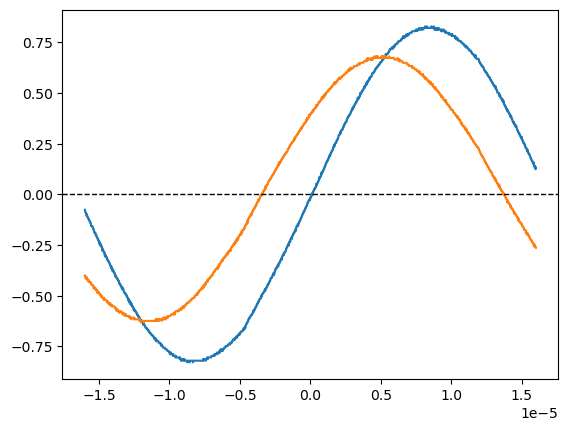

-[day1:21]------------------------------------------------------------------------------
4798464.491362774 Hz, 50241.1575562701 Hz, 50280.56555580137 Hz, 5010020.040080231 Hz
99501.49749753733 Hz
Ampiezza CH1: 1.29 V
Ampiezza CH2: 1.21 V
Rapporto tra le ampiezze 93.7984496124031 %
Sfasamento:  358.0183281758391 % π/2
-[day1:22]------------------------------------------------------------------------------
17857142.857144438 Hz, 17857142.857141282 Hz
17857142.85714286 Hz
Ampiezza CH1: 1.8900000000000001 V
Ampiezza CH2: 1.8399999999999999 V
Rapporto tra le ampiezze 97.35449735449734 %
Sfasamento:  185.71428571428578 % π/2
-[day1:23]------------------------------------------------------------------------------
200642.05457463922 Hz, 199044.5859872608 Hz
199840.12789768187 Hz
Ampiezza CH1: 2.23 V
Ampiezza CH2: 2.1900000000000004 V
Rapporto tra le ampiezze 98.20627802690585 %
Sfasamento:  396.00319744204637 % π/2
-[day1:24]---------------------------------------------------------------------

In [6]:
fasi5B_day1, ampiezze15B_day1, ampiezze25B_day1, ampiezze_rapporto5B_day1, frequenze5B_day1 = \
    analyze([(i, f) for (i, f) in files5B if i.startswith("day1")])
fasi5B_day2, ampiezze15B_day2, ampiezze25B_day2, ampiezze_rapporto5B_day2, frequenze5B_day2 = \
    analyze([(i, f) for (i, f) in files5B if i.startswith("day2")])

fasi5B, ampiezze15B, ampiezze25B, ampiezze_rapporto5B, frequenze5B = (
    fasi5B_day1 + fasi5B_day2,
    ampiezze15B_day1 + ampiezze15B_day2,
    ampiezze25B_day1 + ampiezze25B_day2,
    ampiezze_rapporto5B_day1 + ampiezze_rapporto5B_day2,
    frequenze5B_day1 + frequenze5B_day2
)

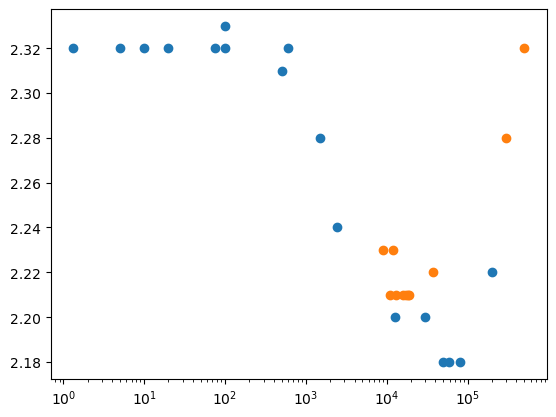

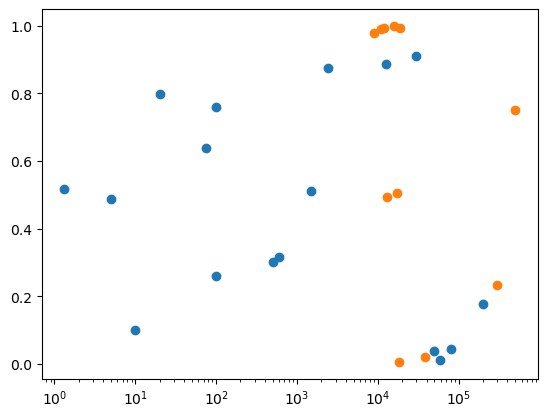

In [7]:
fig, ax = plt.subplots()
ax.scatter(frequenze5A_day1, ampiezze15A_day1)
ax.scatter(frequenze5A_day2, ampiezze15A_day2)
ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
# ax.scatter(frequenze5A, [(phi % 1 if abs(phi) > 1 else phi) + int(nu >= 4e4) for (nu, phi) in zip(frequenze5A, fasi5A)])
ax.scatter(frequenze5A_day1, [phi % 1 for phi in fasi5A_day1])
ax.scatter(frequenze5A_day2, [phi % 1 for phi in fasi5A_day2])
ax.set_xscale('log')
plt.show()